# Categorical Variational Autoencoder Sequence-to-Sequence Model for Speech

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))

import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Utility functions and classes

In [3]:
class SimpleIterator(object):
    
    def __init__(self, x_list, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.indices = np.arange(len(self.x_lengths))
        np.random.shuffle(self.indices)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            np.random.shuffle(self.indices)
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [4]:
class SimpleBucketIterator(object):
    
    i_epoch = 0
    
    def __init__(self, x_list, batch_size, n_buckets, tau_list, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.tau_list = tau_list
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        cur_tau = tau_list[SimpleBucketIterator.i_epoch] if SimpleBucketIterator.i_epoch < len(tau_list) else tau_list[-1]
        SimpleBucketIterator.i_epoch += 1
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths, cur_tau)

## Data

In [5]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 5106
E.g. item shape: (51, 39)


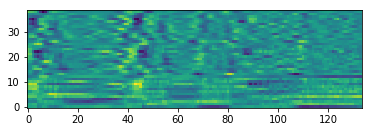

In [6]:
plt.imshow(train_x[3277].T, origin="bottom");

In [7]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [8]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

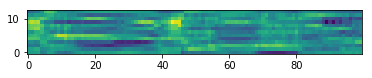

In [9]:
plt.imshow(train_x[3277].T, origin="bottom");

## Sequence-to-sequence model with latent CatVAE representation

In [68]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 150
batch_size = 100
n_buckets = 3

# Model parameters
n_input = d_frame
n_hidden = 150
build_latent_func = tflego.build_catvae
K = 30
N = 4
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "dec_n_hiddens": [n_hidden],
    "activation": tf.nn.relu,
    "K": K,
    "N": N,
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
model_fn = path.join(output_dir, "encdec_lazydynamic_latent_catvae.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_encdec_lazydynamic_latentfunc(
    x, x_lengths, n_hidden, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
catvae = network_dict["latent_layer"]
softmax_logits = catvae["softmax_logits"]
log_logits_categorical = catvae["log_logits_categorical"]
z = catvae["z"]
y = catvae["y"]
tau = catvae["tau"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# Temperature
tau_init = 1.
# anneal_rate = 0.03
tau_min = 1.
tau_list = np.linspace(tau_init, tau_min, n_epochs)

# Loss (KL divergence)
kl_tmp = tf.reshape(softmax_logits*(log_logits_categorical - tf.log(1.0/K)), [-1, N, K])
kl = tf.reduce_sum(kl_tmp, [1, 2])

# CatVAE loss (Gaussian)
sigma_sq = 0.00001
loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x, y) + tf.reduce_mean(kl)
reconstruction_loss = tf.losses.mean_squared_error(x, y)

# # CatVAE loss (Bernoulli)
# y = tf.nn.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     ) + tf.reduce_mean(kl)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [69]:
np.random.seed(1)
train_batch_iterator = SimpleBucketIterator(
    train_x, batch_size, n_buckets, tau_list, True
    )
val_batch_iterator = SimpleBucketIterator(
    val_x, batch_size, n_buckets, [tau_min], False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, [loss, reconstruction_loss, tau], train_batch_iterator,
    [x, x_lengths, tau], [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-08-08 08:20:05.418135
Epoch 0:
3.467 sec, train loss: [  5.06529609e+04   1.01305318e+00   1.00000000e+00], val loss: [  4.49597930e+04   8.99159610e-01] *
Epoch 1:
3.395 sec, train loss: [  4.47889844e+04   8.95737052e-01   1.00000000e+00], val loss: [  4.41310742e+04   8.82573843e-01] *
Epoch 2:
3.398 sec, train loss: [  4.37053008e+04   8.74058425e-01   1.00000000e+00], val loss: [  4.31450820e+04   8.62861872e-01] *
Epoch 3:
3.412 sec, train loss: [  4.29732734e+04   8.59421372e-01   1.00000000e+00], val loss: [  4.25957695e+04   8.51870060e-01] *
Epoch 4:
3.395 sec, train loss: [  4.24773281e+04   8.49498153e-01   1.00000000e+00], val loss: [  4.23864414e+04   8.47681403e-01] *
Epoch 5:
3.396 sec, train loss: [  4.22883203e+04   8.45719755e-01   1.00000000e+00], val loss: [  4.21131562e+04   8.42220068e-01] *
Epoch 6:
3.396 sec, train loss: [  4.20819648e+04   8.41596484e-01   1.00000000e+00], val loss: [  4.17493047e+04   8.34944069e-01] *
Epoch 7:
3.394 sec, train loss: [  

Epoch 62:
3.391 sec, train loss: [  3.81023789e+04   7.62001514e-01   1.00000000e+00], val loss: [  3.94775898e+04   7.89508879e-01]
Epoch 63:
3.393 sec, train loss: [  3.80019297e+04   7.59992719e-01   1.00000000e+00], val loss: [  3.96184180e+04   7.92325854e-01]
Epoch 64:
3.393 sec, train loss: [  3.79339688e+04   7.58633733e-01   1.00000000e+00], val loss: [  3.94413477e+04   7.88784444e-01]
Epoch 65:
3.400 sec, train loss: [  3.78630352e+04   7.57215440e-01   1.00000000e+00], val loss: [  3.94830820e+04   7.89619446e-01]
Epoch 66:
3.399 sec, train loss: [  3.79648594e+04   7.59251893e-01   1.00000000e+00], val loss: [  3.94320430e+04   7.88599014e-01]
Epoch 67:
3.401 sec, train loss: [  3.79305000e+04   7.58564830e-01   1.00000000e+00], val loss: [  3.93060234e+04   7.86078513e-01] *
Epoch 68:
3.398 sec, train loss: [  3.77617812e+04   7.55189776e-01   1.00000000e+00], val loss: [  3.95933555e+04   7.91824818e-01]
Epoch 69:
3.402 sec, train loss: [  3.77039844e+04   7.54034281e-01

Epoch 124:
3.396 sec, train loss: [  3.61099961e+04   7.22156703e-01   1.00000000e+00], val loss: [  3.83045820e+04   7.66052544e-01]
Epoch 125:
3.408 sec, train loss: [  3.61570312e+04   7.23097384e-01   1.00000000e+00], val loss: [  3.84343320e+04   7.68647611e-01]
Epoch 126:
3.396 sec, train loss: [  3.61624219e+04   7.23204672e-01   1.00000000e+00], val loss: [  3.87707148e+04   7.75374949e-01]
Epoch 127:
3.394 sec, train loss: [  3.62231094e+04   7.24418044e-01   1.00000000e+00], val loss: [  3.83777617e+04   7.67515957e-01]
Epoch 128:
3.393 sec, train loss: [  3.60605391e+04   7.21167147e-01   1.00000000e+00], val loss: [  3.84548281e+04   7.69057453e-01]
Epoch 129:
3.396 sec, train loss: [  3.60281133e+04   7.20518827e-01   1.00000000e+00], val loss: [  3.84037578e+04   7.68036187e-01]
Epoch 130:
3.396 sec, train loss: [  3.61869766e+04   7.23696589e-01   1.00000000e+00], val loss: [  3.83426055e+04   7.66813636e-01]
Epoch 131:
3.398 sec, train loss: [  3.60044062e+04   7.200449

In [70]:
# Embed validation
tau_eval = tau_min
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: tau_eval}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: tau_eval}
            )[0]
        break  # single batch
np_z = np_z.reshape(-1, N*K)

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/encdec_lazydynamic_latent_catvae.ckpt


In [80]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.0086
Precision-recall breakeven: 0.0270


In [83]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.0087
Precision-recall breakeven: 0.0284


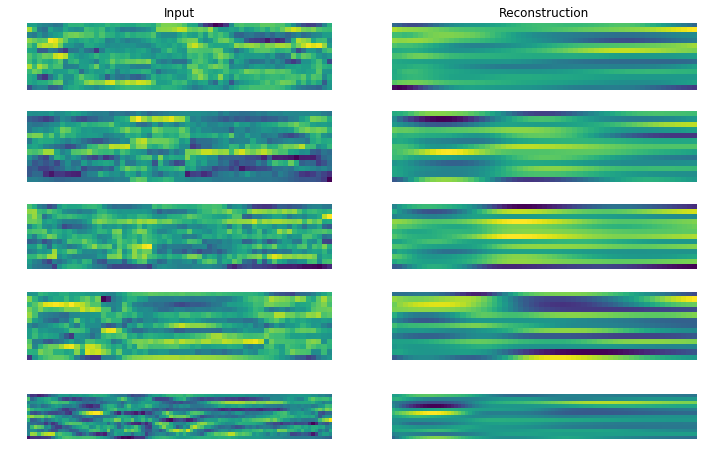

In [84]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

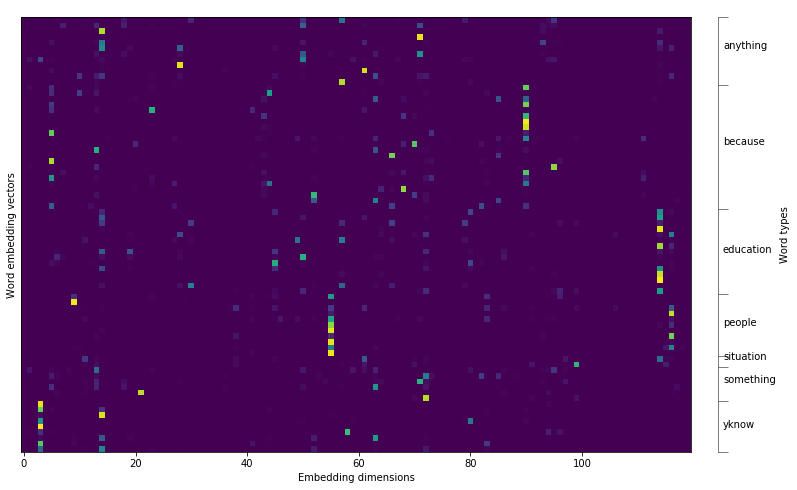

In [82]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )